In [2]:
import pandas as pd
import numpy as np
from pprint import pprint

# Load the labeled dataset
df = pd.read_csv("labeled_gait_output.csv")

# Initialize dictionary to store features
features = {}

# ---------------
# Time Features
# ---------------
features["duration_sec"] = (df["Time"].iloc[-1] - df["Time"].iloc[0]) / 1000.0

# ---------------
# Force Features
# ---------------
for side in ["Left", "Right"]:
    force_col = f"{side}_Force"
    features[f"{side}_force_mean"] = df[force_col].mean()
    features[f"{side}_force_std"] = df[force_col].std()
    features[f"{side}_force_range"] = df[force_col].max() - df[force_col].min()

# ---------------
# Joint Angle Features
# ---------------
for side in ["Left", "Right"]:
    angle_col = f"{side}_Ankle_Angle"
    features[f"{side}_angle_mean"] = df[angle_col].mean()
    features[f"{side}_angle_std"] = df[angle_col].std()
    features[f"{side}_angle_range"] = df[angle_col].max() - df[angle_col].min()
    features[f"{side}_angle_max"] = df[angle_col].max()
    features[f"{side}_angle_min"] = df[angle_col].min()

# ---------------
# Gait Phase Duration Features
# ---------------
for side in ["Left", "Right"]:
    phase_col = f"{side}_Gait_Phase"
    total_frames = len(df)
    phase_counts = df[phase_col].value_counts(normalize=True)  # % of time
    for phase in ["Stance", "Swing", "Heel Strike", "Toe-Off"]:
        features[f"{side}_phase_pct_{phase.replace(' ', '_')}"] = phase_counts.get(phase, 0.0) * 100

# ---------------
# Symmetry Features
# ---------------
def symmetry_index(val_left, val_right):
    return abs(val_left - val_right) / max((val_left + val_right) / 2, 1e-6) * 100

features["angle_symmetry_index"] = symmetry_index(
    features["Left_angle_mean"], features["Right_angle_mean"]
)
features["force_symmetry_index"] = symmetry_index(
    features["Left_force_mean"], features["Right_force_mean"]
)
features["stance_symmetry_index"] = symmetry_index(
    features["Left_phase_pct_Stance"], features["Right_phase_pct_Stance"]
)

# ---------------
# Print Final Feature Set
# ---------------
print("✅ Gait ML Features:")
pprint(features)


✅ Gait ML Features:
{'Left_angle_max': 2.6962567452004795,
 'Left_angle_mean': -0.0824857443623432,
 'Left_angle_min': -5.074725231791542,
 'Left_angle_range': 7.770981976992022,
 'Left_angle_std': 1.550926273170912,
 'Left_force_mean': 1181.603045112782,
 'Left_force_range': 3238.219828465305,
 'Left_force_std': 1110.1462956601595,
 'Left_phase_pct_Heel_Strike': 0.2556390977443609,
 'Left_phase_pct_Stance': 53.72932330827067,
 'Left_phase_pct_Swing': 45.774436090225564,
 'Left_phase_pct_Toe-Off': 0.24060150375939848,
 'Right_angle_max': 18.410510674379648,
 'Right_angle_mean': 0.18119693713854773,
 'Right_angle_min': -22.09974464352159,
 'Right_angle_range': 40.51025531790124,
 'Right_angle_std': 9.328622033897377,
 'Right_force_mean': 893.114022556391,
 'Right_force_range': 2935.204654931367,
 'Right_force_std': 861.88534266309,
 'Right_phase_pct_Heel_Strike': 0.24060150375939848,
 'Right_phase_pct_Stance': 34.79699248120301,
 'Right_phase_pct_Swing': 64.7218045112782,
 'Right_phase_

heel strike 0
stance 1
Swing 2
toe-off 3

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [7]:
# -------------------------------
# 1. Load Data
# -------------------------------
df = pd.read_csv("labeled_gait_output.csv")

# Features from both sides for full-body context
features = [
    "LT_GyroX_filtered", "LT_GyroY_filtered", "LT_GyroZ_filtered",
    "LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered",
    "LA_GyroX_filtered", "LA_GyroY_filtered", "LA_GyroZ_filtered",
    "Left_Ankle_Angle", "Left_Force",
    "RT_GyroX_filtered", "RT_GyroY_filtered", "RT_GyroZ_filtered",
    "RS_GyroX_filtered", "RS_GyroY_filtered", "RS_GyroZ_filtered",
    "RA_GyroX_filtered", "RA_GyroY_filtered", "RA_GyroZ_filtered",
    "Right_Ankle_Angle", "Right_Force"
]

X = df[features]
y_raw = df["Left_Gait_Phase"]

In [8]:

# -------------------------------
# 2. Encode Labels
# -------------------------------
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_

In [9]:
print(df["Left_Gait_Phase"].value_counts())

Left_Gait_Phase
Stance         3573
Swing          3044
Heel Strike      17
Toe-Off          16
Name: count, dtype: int64


In [10]:
# -------------------------------
# 3. Split Data
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [11]:
# -------------------------------
# 4. Define Classifiers
# -------------------------------
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=1000,class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine (SVM)": SVC(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier()
}


🔍 Training: Random Forest
✅ Accuracy: 0.9947
              precision    recall  f1-score   support

 Heel Strike       0.00      0.00      0.00         3
      Stance       0.99      1.00      1.00       715
       Swing       1.00      1.00      1.00       609
     Toe-Off       0.00      0.00      0.00         3

    accuracy                           0.99      1330
   macro avg       0.50      0.50      0.50      1330
weighted avg       0.99      0.99      0.99      1330



/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

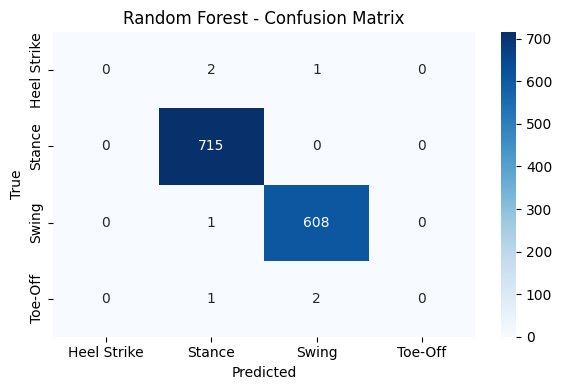


🔍 Training: Logistic Regression
✅ Accuracy: 0.9128
              precision    recall  f1-score   support

 Heel Strike       0.06      1.00      0.12         3
      Stance       0.98      0.94      0.96       715
       Swing       0.99      0.88      0.93       609
     Toe-Off       0.02      0.33      0.04         3

    accuracy                           0.91      1330
   macro avg       0.51      0.79      0.51      1330
weighted avg       0.98      0.91      0.94      1330



/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


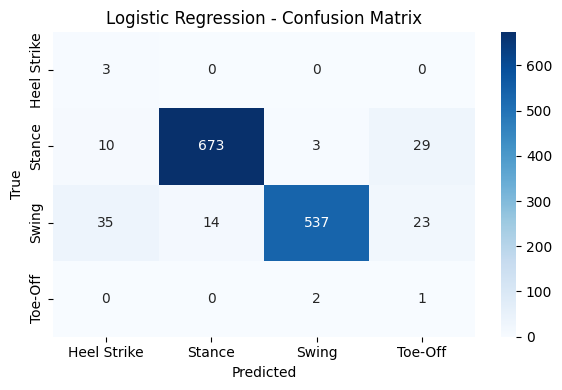


🔍 Training: K-Nearest Neighbors
✅ Accuracy: 0.9955
              precision    recall  f1-score   support

 Heel Strike       0.67      0.67      0.67         3
      Stance       1.00      1.00      1.00       715
       Swing       1.00      1.00      1.00       609
     Toe-Off       0.00      0.00      0.00         3

    accuracy                           1.00      1330
   macro avg       0.66      0.67      0.67      1330
weighted avg       0.99      1.00      0.99      1330



/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

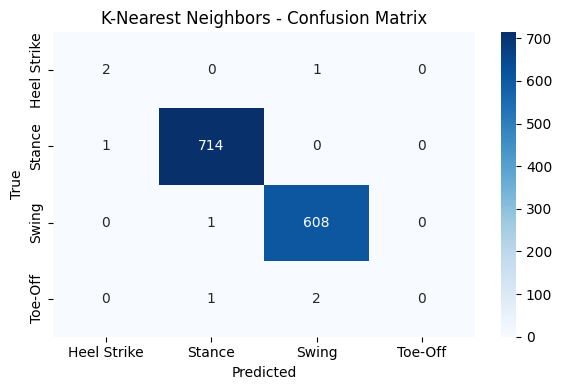


🔍 Training: Support Vector Machine (SVM)
✅ Accuracy: 0.9203
              precision    recall  f1-score   support

 Heel Strike       0.07      1.00      0.13         3
      Stance       1.00      0.95      0.97       715
       Swing       1.00      0.89      0.94       609
     Toe-Off       0.03      0.67      0.06         3

    accuracy                           0.92      1330
   macro avg       0.52      0.88      0.52      1330
weighted avg       0.99      0.92      0.95      1330



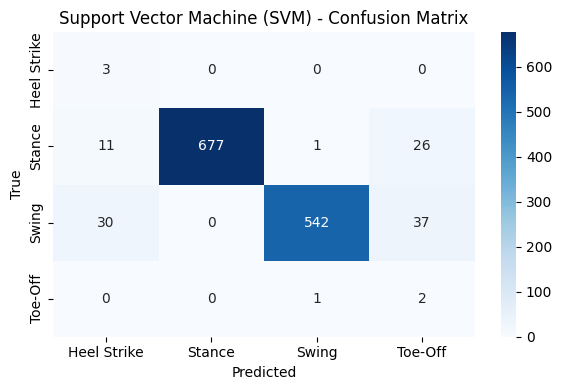


🔍 Training: Gradient Boosting
✅ Accuracy: 0.9947
              precision    recall  f1-score   support

 Heel Strike       1.00      0.67      0.80         3
      Stance       1.00      1.00      1.00       715
       Swing       1.00      1.00      1.00       609
     Toe-Off       0.00      0.00      0.00         3

    accuracy                           0.99      1330
   macro avg       0.75      0.67      0.70      1330
weighted avg       0.99      0.99      0.99      1330



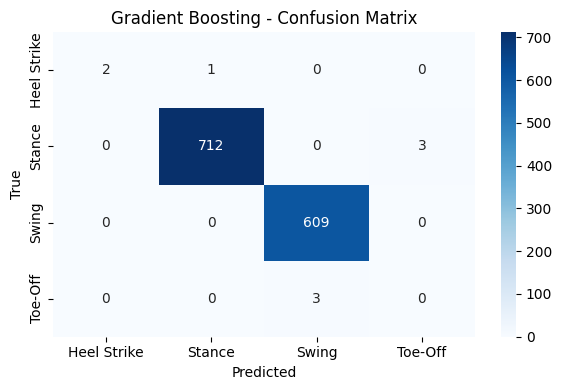

In [12]:
# -------------------------------
# 5. Train & Evaluate
# -------------------------------
for name, model in models.items():
    print(f"\n🔍 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

2025-04-23 23:11:22.580999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-23 23:12:25.459593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 23:12:25.463073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-04-23 23:12:27.193049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and y

Epoch 1/15


2025-04-23 23:12:28.343403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 23:12:28.344630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 23:12:28.345477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

67/67 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.9328

2025-04-23 23:12:38.458381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 23:12:38.459243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 23:12:38.460167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

67/67 [==============================] - 12s 74ms/step - loss: 0.2441 - accuracy: 0.9328 - val_loss: 0.0870 - val_accuracy: 0.9746
Epoch 2/15
67/67 [==============================] - 3s 42ms/step - loss: 0.0663 - accuracy: 0.9783 - val_loss: 0.0693 - val_accuracy: 0.9689
Epoch 3/15
67/67 [==============================] - 2s 37ms/step - loss: 0.0493 - accuracy: 0.9842 - val_loss: 0.0479 - val_accuracy: 0.9840
Epoch 4/15
67/67 [==============================] - 3s 39ms/step - loss: 0.0332 - accuracy: 0.9882 - val_loss: 0.0311 - val_accuracy: 0.9915
Epoch 5/15
67/67 [==============================] - 3s 39ms/step - loss: 0.0380 - accuracy: 0.9875 - val_loss: 0.0327 - val_accuracy: 0.9877
Epoch 6/15
67/67 [==============================] - 3s 38ms/step - loss: 0.0310 - accuracy: 0.9913 - val_loss: 0.0279 - val_accuracy: 0.9906
Epoch 7/15
67/67 [==============================] - 3s 42ms/step - loss: 0.0368 - accuracy: 0.9885 - val_loss: 0.0438 - val_accuracy: 0.9887
Epoch 8/15
67/67 [=====

2025-04-23 23:13:16.155271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 23:13:16.156407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 23:13:16.157116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - 1s 14ms/step
Classification Report:
              precision    recall  f1-score   support

 Heel Strike       0.00      0.00      0.00         3
      Stance       1.00      1.00      1.00       711
       Swing       0.99      1.00      1.00       609
     Toe-Off       0.00      0.00      0.00         3

    accuracy                           0.99      1326
   macro avg       0.50      0.50      0.50      1326
weighted avg       0.99      0.99      0.99      1326



/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

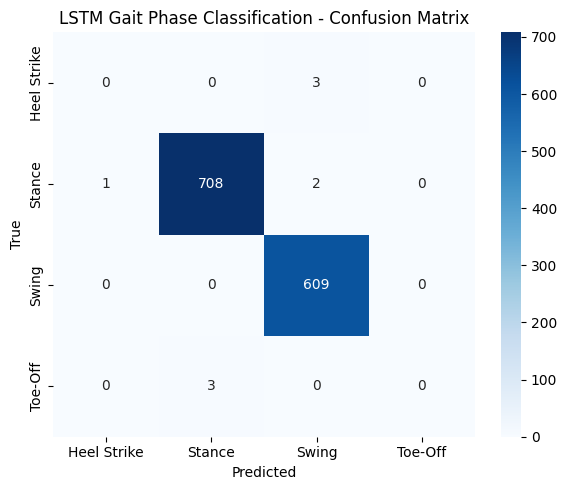

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv("labeled_gait_output.csv")

# Define Feature Columns
feature_cols = [
    "LT_GyroX_filtered", "LT_GyroY_filtered", "LT_GyroZ_filtered",
    "LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered",
    "LA_GyroX_filtered", "LA_GyroY_filtered", "LA_GyroZ_filtered",
    "Left_Ankle_Angle", "Left_Force",
    "RT_GyroX_filtered", "RT_GyroY_filtered", "RT_GyroZ_filtered",
    "RS_GyroX_filtered", "RS_GyroY_filtered", "RS_GyroZ_filtered",
    "RA_GyroX_filtered", "RA_GyroY_filtered", "RA_GyroZ_filtered",
    "Right_Ankle_Angle", "Right_Force"
]

# Sequence Generation
def create_sliding_sequences(df, feature_cols, label_col, window_size=20, stride=1):
    sequences, labels = [], []
    le = LabelEncoder()
    df["EncodedLabel"] = le.fit_transform(df[label_col])
    for start in range(0, len(df) - window_size, stride):
        end = start + window_size
        X_window = df[feature_cols].iloc[start:end].to_numpy()
        y_label = df["EncodedLabel"].iloc[end - 1]
        sequences.append(X_window)
        labels.append(y_label)
    return np.array(sequences), np.array(labels), le

X, y, le = create_sliding_sequences(df, feature_cols, "Left_Gait_Phase", window_size=20)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# LSTM Model
def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_lstm_model((X.shape[1], X.shape[2]), len(le.classes_))

# Train Model
history = model.fit(X_train, y_train_cat, epochs=15, batch_size=64, validation_split=0.2, verbose=1)

# Evaluation
y_pred = model.predict(X_test).argmax(axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("LSTM Gait Phase Classification - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

\n🚀 Training model: LSTM


2025-04-23 23:17:20.098360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 23:17:20.101627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 23:17:20.102534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2025-04-23 23:17:20.747684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 23:17:20.748970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 23:17:20.749857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

67/67 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9503

2025-04-23 23:17:27.178665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 23:17:27.179576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 23:17:27.180672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

67/67 [==============================] - 7s 52ms/step - loss: 0.2004 - accuracy: 0.9503 - val_loss: 0.0864 - val_accuracy: 0.9680
Epoch 2/10
67/67 [==============================] - 3s 38ms/step - loss: 0.0768 - accuracy: 0.9783 - val_loss: 0.0716 - val_accuracy: 0.9783
Epoch 3/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0644 - accuracy: 0.9804 - val_loss: 0.0368 - val_accuracy: 0.9877
Epoch 4/10
67/67 [==============================] - 3s 38ms/step - loss: 0.0437 - accuracy: 0.9866 - val_loss: 0.0316 - val_accuracy: 0.9906
Epoch 5/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0330 - accuracy: 0.9908 - val_loss: 0.0321 - val_accuracy: 0.9915
Epoch 6/10
67/67 [==============================] - 2s 36ms/step - loss: 0.0339 - accuracy: 0.9885 - val_loss: 0.0283 - val_accuracy: 0.9934
Epoch 7/10
67/67 [==============================] - 3s 42ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.0301 - val_accuracy: 0.9906
Epoch 8/10
67/67 [======

2025-04-23 23:17:51.751559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 23:17:51.752775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 23:17:51.753716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - 1s 9ms/step
\n📊 Classification Report for LSTM:
              precision    recall  f1-score   support

 Heel Strike       0.00      0.00      0.00         3
      Stance       0.99      1.00      1.00       711
       Swing       0.99      0.99      0.99       609
     Toe-Off       0.00      0.00      0.00         3

    accuracy                           0.99      1326
   macro avg       0.50      0.50      0.50      1326
weighted avg       0.99      0.99      0.99      1326



/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manoj/Documents/gait-research/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

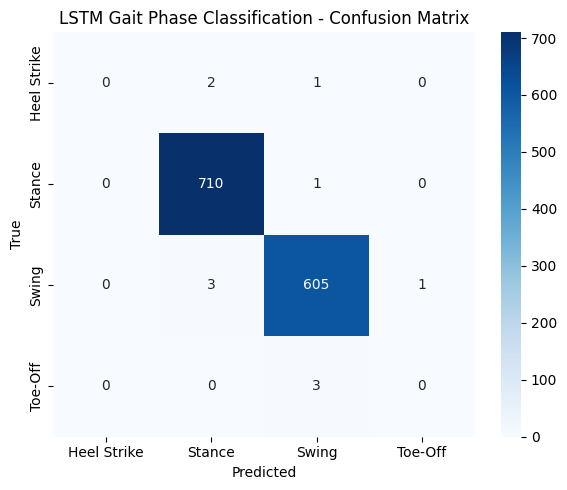

\n🚀 Training model: BiLSTM


2025-04-23 23:17:53.019143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 23:17:53.020900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 23:17:53.021717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2025-04-23 23:17:53.710642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-23 23:17:53.711689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-23 23:17:53.712561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

: 

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv("labeled_gait_output.csv")

# Feature Columns
feature_cols = [
    "LT_GyroX_filtered", "LT_GyroY_filtered", "LT_GyroZ_filtered",
    "LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered",
    "LA_GyroX_filtered", "LA_GyroY_filtered", "LA_GyroZ_filtered",
    "Left_Ankle_Angle", "Left_Force",
    "RT_GyroX_filtered", "RT_GyroY_filtered", "RT_GyroZ_filtered",
    "RS_GyroX_filtered", "RS_GyroY_filtered", "RS_GyroZ_filtered",
    "RA_GyroX_filtered", "RA_GyroY_filtered", "RA_GyroZ_filtered",
    "Right_Ankle_Angle", "Right_Force"
]

# Sequence Generator
def create_sliding_sequences(df, feature_cols, label_col, window_size=20, stride=1):
    sequences, labels = [], []
    le = LabelEncoder()
    df["EncodedLabel"] = le.fit_transform(df[label_col])
    for start in range(0, len(df) - window_size, stride):
        end = start + window_size
        X_window = df[feature_cols].iloc[start:end].to_numpy()
        y_label = df["EncodedLabel"].iloc[end - 1]
        sequences.append(X_window)
        labels.append(y_label)
    return np.array(sequences), np.array(labels), le

X, y, le = create_sliding_sequences(df, feature_cols, "Left_Gait_Phase", window_size=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Model Variants
def build_lstm(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_bilstm(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_cnn1d(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_cnn_lstm(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

models = {
    "LSTM": build_lstm,
    "BiLSTM": build_bilstm,
    "CNN1D": build_cnn1d,
    "CNN+LSTM": build_cnn_lstm
}

# Train and Evaluate Each Model
for name, builder in models.items():
    print(f"\\n🚀 Training model: {name}")
    model = builder((X.shape[1], X.shape[2]), len(le.classes_))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
    plt.title(f"{name} Gait Phase Classification - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
